Importing libraries

In [504]:
import numpy as np
import pandas as pd
import json

Loading data

In [505]:
with open('steam_games.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

In [506]:
df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,f7ccb8df,"[Action, Adventure, Casual]",f39b8eba2222,f39b8eba2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,f7ccb8df,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


For Content-based recommendations we will be using these features of the dataset. The rest are dropped

In [507]:
df = df[['id', 'app_name', 'developer', 'genres', 'specs', 'tags', 'price', 'release_date', 'early_access']]
df.head()

,id,app_name,developer,genres,specs,tags,price,release_date,early_access
0,761140,Lost Summoner Kitty,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",4.99,2018-01-04,False
1,643980,Ironbound,Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,2018-01-04,False
2,670290,Real Pool 3D - Poolians,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,2017-07-24,False
3,767400,f39b8eba2222,f7ccb8df,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",0.99,2017-12-07,False
4,773570,Log Challenge,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",2.99,NaN,False


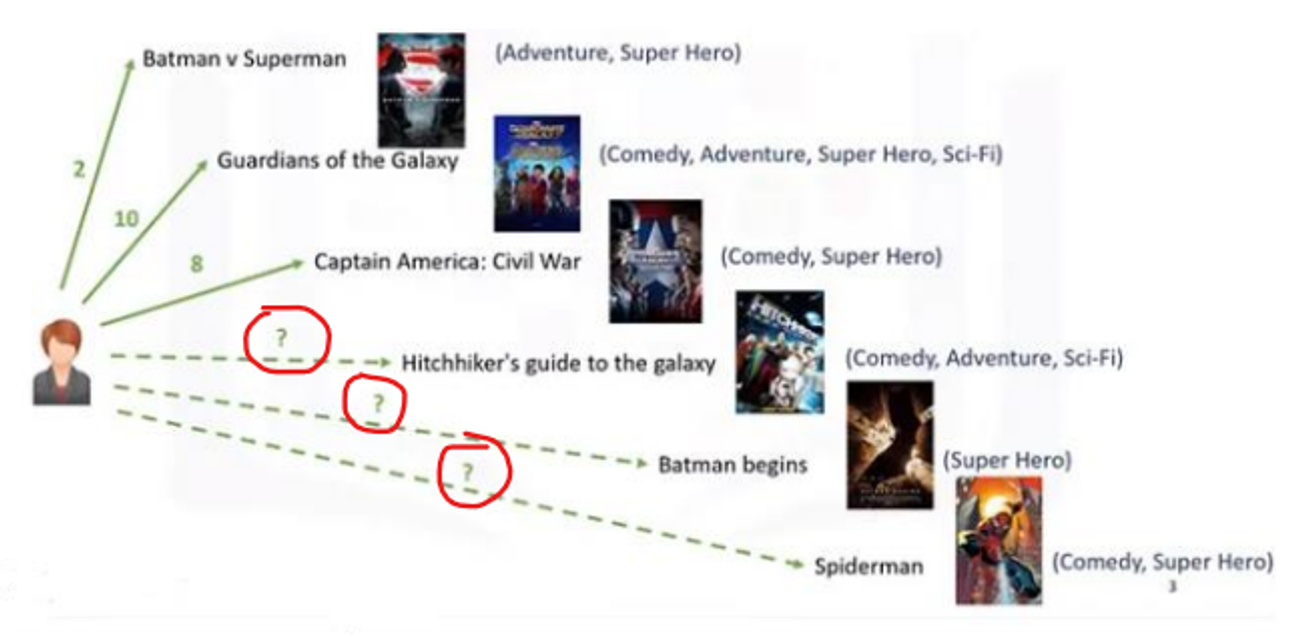

The release date is converted to just the release year

In [508]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year
df = df.drop('release_date', axis=1)

The dataset had strings like 'Free' written in the Price column in some areas. Replace all that with 0 price

In [509]:
df['price'] = df['price'].replace(to_replace=r'.*Free.*', value=0, regex=True)
df['price'] = df['price'].replace(to_replace=r'.*Play.*', value=0, regex=True)
df['price'] = df['price'].replace(to_replace=r'.*Install.*', value=0, regex=True)
df['price'] = df['price'].replace(to_replace=r'.*Install.*', value=0, regex=True)
df = df[df['price'] != 'Third-party']

If the specs, tags of genres rows are null replace them with an empty list

In [510]:
df['specs'] = df['specs'].apply(lambda x: x if isinstance(x, list) else [])
df['tags'] = df['tags'].apply(lambda x: x if isinstance(x, list) else [])
df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])

Handle the remaining null values in the dataset

In [511]:
df['developer'] = df['developer'].fillna('NA')
df['app_name'] = df['app_name'].fillna('NA')
df['id'] = df['id'].fillna('NA')
df['early_access'] = df['early_access'].fillna(False)
df['year'] = df['year'].fillna(-1)
df['price'] = df['price'].fillna(-1)

Some column values need to be adjusted to make them sound more like attributes of the game

Early Access True/False is renamed to "Early Access"/"Not Early Access"

In [512]:
df['early_access'] = df['early_access'].map({True: 'Early Access', False: 'Not Early Access'})

Year and Price are converted to strings

In [513]:
df['year'] = df['year'].astype(int).astype(str)
df['year'] = 'Released in ' + df['year'] 
df['price'] = df['price'].astype(float).astype(str)
df['price'] = 'Price of $' + df['price']


A new column is added that contains the union of all the attributes of each row

In [514]:
def combine_attributes(row):
    # Initialize an empty list to collect attributes
    attributes = set()
    # Add list columns
    attributes.update(row['genres'])
    attributes.update(row['specs'])
    attributes.update(row['tags'])
    # Add string columns
    attributes.add(row['price'])
    attributes.add(row['early_access'])
    attributes.add(row['year'])
    return sorted(attributes)

df['combined_attributes'] = df.apply(combine_attributes, axis=1)
df

,id,app_name,developer,genres,specs,tags,price,early_access,year,combined_attributes
0,761140,Lost Summoner Kitty,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",Price of $4.99,Not Early Access,Released in 2018,"[Action, Casual, Indie, Not Early Access, Pric..."
1,643980,Ironbound,Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Price of $0.0,Not Early Access,Released in 2018,"[2D, Board Game, Card Game, Character Customiz..."
2,670290,Real Pool 3D - Poolians,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Price of $0.0,Not Early Access,Released in 2017,"[Casual, Free to Play, In-App Purchases, Indie..."
3,767400,f39b8eba2222,f7ccb8df,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",Price of $0.99,Not Early Access,Released in 2017,"[Action, Adventure, Casual, Not Early Access, ..."
4,773570,Log Challenge,NA,[],"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",Price of $2.99,Not Early Access,Released in -1,"[Action, Casual, Full controller support, HTC ..."
...,...,...,...,...,...,...,...,...,...,...
32130,773640,Colony On Mars,Nikita Ghost_RUS,"[Casual, Indie, Simulation, Strategy]","[Single-player, Steam Achievements]","[Strategy, Indie, Casual, Simulation]",Price of $1.99,Not Early Access,Released in 2018,"[Casual, Indie, Not Early Access, Price of $1...."
32131,733530,LOGistICAL: South Africa,Sacada,"[Casual, Indie, Strategy]","[Single-player, Steam Achievements, Steam Clou...","[Strategy, Indie, Casual]",Price of $4.99,Not Early Access,Released in 2018,"[Casual, Indie, Not Early Access, Price of $4...."
32132,610660,Russian Roads,Laush Dmitriy Sergeevich,"[Indie, Racing, Simulation]","[Single-player, Steam Achievements, Steam Trad...","[Indie, Simulation, Racing]",Price of $1.99,Not Early Access,Released in 2018,"[Indie, Not Early Access, Price of $1.99, Raci..."
32133,658870,EXIT 2 - Directions,"xropi,stev3ns","[Casual, Indie]","[Single-player, Steam Achievements, Steam Cloud]","[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",Price of $4.99,Not Early Access,Released in 2017,"[Atmospheric, Casual, Indie, Not Early Access,..."


Getting user input
For testing you can enter the following IDs:
331600 323470 607890

In [515]:
print("To start, we'll need the IDs of your top 3 rated games as well as the ratings you'd give them.")

try:
    game_id_list = input("Please enter the IDs of your top 3 rated games (separated by space): ").strip().split(' ')
    if any(game not in df['id'].values for game in game_id_list):
        raise ValueError("That game ID doesn't exist!")
    if len(game_id_list) != 3:
        raise ValueError('There must be exactly 3 game IDs!')
    
except ValueError as err:
    print(f'\n\x1b[31m{err} Please enter the IDs again, separated by a space.\x1b[0m')
except:
    print('\n\x1b[31mInvalid format! Please enter the IDs again, separated by a space.\x1b[0m')

try:
    user_game_ratings = input("Please enter your ratings out of 10 for each of your games (separated by space): ").strip().split(' ')
    user_game_ratings = [int(item) for item in user_game_ratings]
    if any(rating > 10 or rating < 1 for rating in user_game_ratings):
        raise ValueError('Ratings must be from 1 to 10!')
    if len(user_game_ratings) != 3:
        raise ValueError('There must be exactly 3 ratings!')
    
except ValueError as err:
    print(f'\n\x1b[31m{err} Please enter the ratings again, separated by a space.\x1b[0m')
except:
    print('\n\x1b[31mInvalid format! Please enter the ratings again, separated by a space.\x1b[0m')

top_user_games = df[df['id'].isin(game_id_list)].copy()
top_user_games = top_user_games[['id', 'app_name', 'combined_attributes']]
top_user_games['user_rating'] = user_game_ratings

To start, we'll need the IDs of your top 3 rated games as well as the ratings you'd give them.


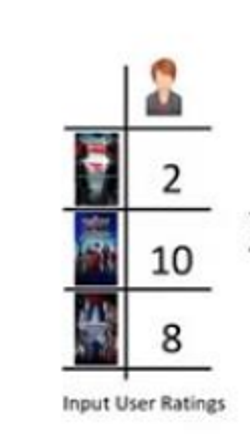

User preferred games along with their user ratings

In [516]:
# 268050 254700 21690
top_user_games

,id,app_name,combined_attributes,user_rating
3240,323470,DRAGON BALL XENOVERSE,"[Action, Action RPG, Adventure, Anime, Beat 'e...",10
4294,331600,One Piece Pirate Warriors 3,"[Action, Adventure, Anime, Beat 'em up, Co-op,...",10
14557,607890,Sword Art Online: Hollow Realization Deluxe Ed...,"[Action, Adventure, Anime, Casual, Character C...",10


This set is the union of all 3 preferred games' combined attributes

In [517]:
top_game_attrs = set()

for _, item in top_user_games.iterrows():
    top_game_attrs.update(item['combined_attributes'])

top_game_attrs = sorted(list(top_game_attrs))

Create a one-hot encoded matrix for the rated games

In [527]:
one_hot_encoded_df = pd.DataFrame(0, index=top_user_games.index, columns=top_game_attrs)

# Fill the DataFrame with 1s where the attribute is present
for index, row in top_user_games.iterrows():
    for attr in row['combined_attributes']:
        if attr in one_hot_encoded_df.columns:
            one_hot_encoded_df.at[index, attr] = 1

rated_games_one_hot_matrix = {}
for id, item in one_hot_encoded_df.iterrows():
    rated_games_one_hot_matrix[id] = one_hot_encoded_df.loc[id].to_numpy()

rated_games_one_hot_matrix

{3240: array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 1, 0], dtype=int64),
 4294: array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 0], dtype=int64),
 14557: array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 1], dtype=int64)}

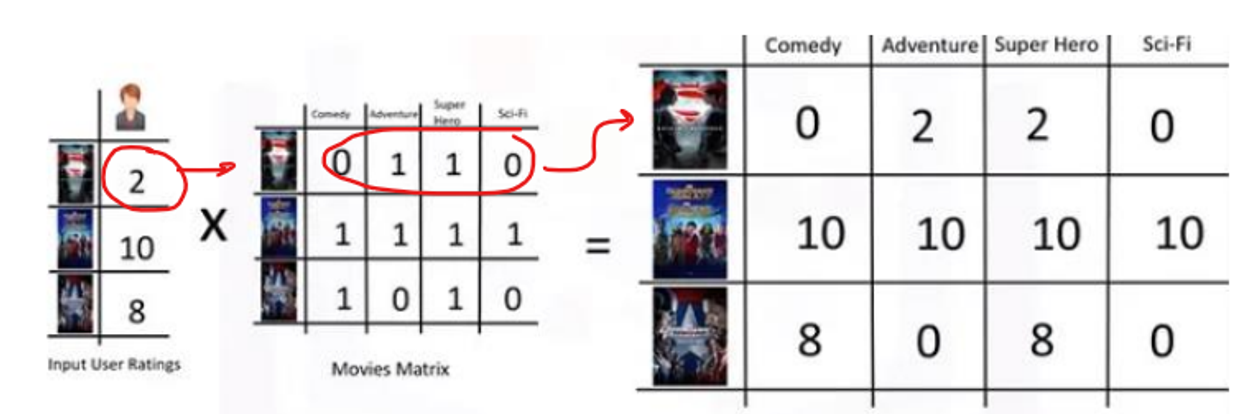

Create the rated movies matrix

In [528]:
rated_games_matrix = []
for one_hot, rating in zip(rated_games_one_hot_matrix.values(), user_game_ratings):
    rated_games_matrix.append([item * rating for item in one_hot])

rated_games_matrix = np.array(rated_games_matrix)
rated_games_matrix

array([[10, 10, 10, 10, 10,  0, 10, 10,  0, 10,  0, 10, 10, 10, 10, 10,
        10,  0,  0,  0,  0, 10,  0,  0, 10, 10, 10,  0, 10,  0,  0, 10,
         0,  0, 10,  0,  0, 10, 10,  0,  0,  0, 10, 10, 10, 10, 10, 10,
         0,  0, 10,  0],
       [10,  0, 10, 10, 10,  0,  0, 10, 10, 10,  0,  0,  0,  0, 10,  0,
        10, 10, 10,  0, 10, 10,  0,  0,  0, 10, 10,  0,  0,  0,  0, 10,
        10, 10, 10,  0,  0,  0, 10,  0,  0, 10, 10, 10, 10,  0,  0,  0,
        10, 10, 10,  0],
       [10,  0, 10, 10,  0, 10, 10, 10,  0,  0, 10,  0,  0,  0,  0,  0,
         0,  0, 10, 10, 10,  0, 10, 10,  0, 10, 10, 10,  0, 10, 10, 10,
        10,  0,  0, 10, 10, 10,  0, 10, 10,  0, 10, 10, 10, 10,  0,  0,
         0,  0,  0, 10]], dtype=int64)

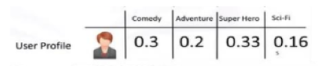

Create the user profile

In [520]:
user_profile = np.array([item/rated_games_matrix.sum() for item in rated_games_matrix.sum(axis=0)])
user_profile

array([0.03488372, 0.01162791, 0.03488372, 0.03488372, 0.02325581,
       0.01162791, 0.02325581, 0.03488372, 0.01162791, 0.02325581,
       0.01162791, 0.01162791, 0.01162791, 0.01162791, 0.02325581,
       0.01162791, 0.02325581, 0.01162791, 0.02325581, 0.01162791,
       0.02325581, 0.02325581, 0.01162791, 0.01162791, 0.01162791,
       0.03488372, 0.03488372, 0.01162791, 0.01162791, 0.01162791,
       0.01162791, 0.03488372, 0.02325581, 0.01162791, 0.02325581,
       0.01162791, 0.01162791, 0.02325581, 0.02325581, 0.01162791,
       0.01162791, 0.01162791, 0.03488372, 0.03488372, 0.03488372,
       0.02325581, 0.01162791, 0.01162791, 0.01162791, 0.01162791,
       0.02325581, 0.01162791])

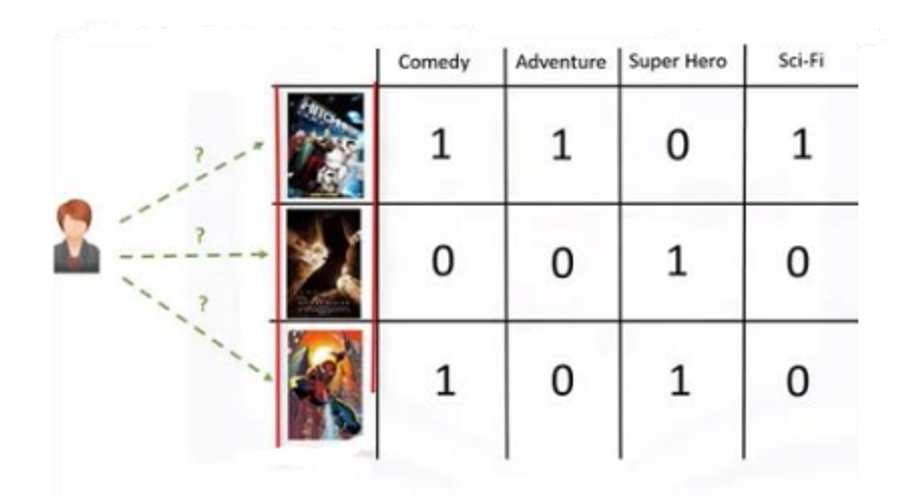

Get the list of unrated games

In [530]:
mask = df['id'].isin(top_user_games['id'].values)

unrated_df = df[~mask]
unrated_df.head()

,id,app_name,developer,genres,specs,tags,price,early_access,year,combined_attributes
0,761140,Lost Summoner Kitty,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",Price of $4.99,Not Early Access,Released in 2018,"[Action, Casual, Indie, Not Early Access, Pric..."
1,643980,Ironbound,Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",Price of $0.0,Not Early Access,Released in 2018,"[2D, Board Game, Card Game, Character Customiz..."
2,670290,Real Pool 3D - Poolians,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",Price of $0.0,Not Early Access,Released in 2017,"[Casual, Free to Play, In-App Purchases, Indie..."
3,767400,f39b8eba2222,f7ccb8df,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",Price of $0.99,Not Early Access,Released in 2017,"[Action, Adventure, Casual, Not Early Access, ..."
4,773570,Log Challenge,NA,[],"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",Price of $2.99,Not Early Access,Released in -1,"[Action, Casual, Full controller support, HTC ..."


Create a one-hot matrix for the unrated games (takes a few seconds because theres 32000 rows to traverse)

In [531]:
one_hot_encoded_df = pd.DataFrame(0, index=unrated_df.index, columns=top_game_attrs)

# Fill the DataFrame with 1s where the attribute is present
for index, row in unrated_df.iterrows():
    for attr in row['combined_attributes']:
        if attr in one_hot_encoded_df.columns:
            one_hot_encoded_df.at[index, attr] = 1

unrated_games_one_hot_matrix = {}
for id, item in one_hot_encoded_df.iterrows():
    unrated_games_one_hot_matrix[id] = one_hot_encoded_df.loc[id].to_numpy()

unrated_games_one_hot_matrix


{0: array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0], dtype=int64),
 1: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0], dtype=int64),
 2: array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 3: array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 4: array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 5: array(

Create the unrated games matrix

In [532]:
unrated_games_matrix = {}

for game_id, one_hot in unrated_games_one_hot_matrix.items():
    one_hot = np.array(one_hot)
    unrated_games_matrix[game_id] = one_hot * user_profile

unrated_games_matrix

{0: array([0.03488372, 0.        , 0.        , 0.        , 0.        ,
        0.01162791, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.03488372, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.03488372, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01162791,
        0.        , 0.        ]),
 1: array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02325581, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01162791, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        

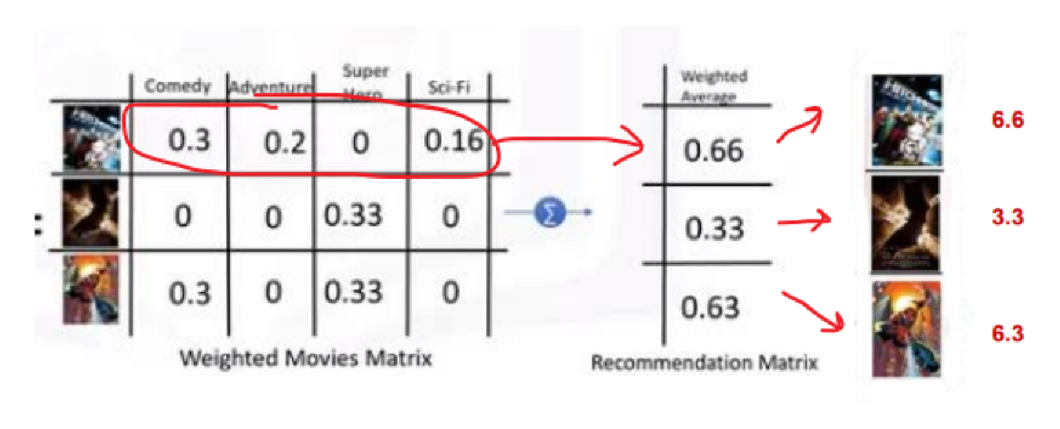

Use the user profile and unrated game matrix to obtain predicted ratings for every unrated game

In [533]:
predicted_rating_list = {}
for game_id, game_weights in unrated_games_matrix.items():
    predicted_rating_list[game_id] = round(game_weights.sum()*10, 1)

predicted_rating_list

{0: 1.3,
 1: 2.1,
 2: 1.5,
 3: 1.6,
 4: 1.3,
 5: 2.0,
 6: 1.9,
 7: 1.9,
 8: 1.9,
 9: 1.2,
 10: 0.7,
 11: 0.8,
 12: 2.1,
 13: 0.8,
 14: 0.8,
 15: 1.9,
 16: 1.9,
 17: 1.9,
 18: 1.9,
 19: 0.3,
 20: 1.3,
 21: 1.4,
 22: 1.2,
 23: 1.5,
 24: 1.2,
 25: 1.4,
 26: 0.3,
 27: 2.0,
 28: 2.7,
 29: 1.3,
 30: 1.5,
 31: 2.0,
 32: 1.2,
 33: 0.8,
 34: 1.9,
 35: 1.6,
 36: 1.3,
 37: 2.4,
 38: 2.0,
 39: 2.1,
 40: 1.6,
 41: 3.0,
 42: 1.5,
 43: 2.1,
 44: 0.9,
 45: 0.7,
 46: 0.9,
 47: 2.4,
 48: 2.0,
 49: 1.0,
 50: 1.5,
 51: 0.3,
 52: 2.2,
 53: 1.5,
 54: 1.3,
 55: 1.7,
 56: 1.9,
 57: 1.6,
 58: 3.7,
 59: 1.0,
 60: 0.8,
 61: 1.2,
 62: 1.6,
 63: 0.8,
 64: 2.2,
 65: 2.3,
 66: 2.2,
 67: 2.3,
 68: 0.8,
 69: 2.2,
 70: 2.8,
 71: 0.8,
 72: 1.3,
 73: 1.7,
 74: 0.3,
 75: 1.2,
 76: 2.0,
 77: 1.2,
 78: 2.2,
 79: 3.6,
 80: 1.7,
 81: 2.2,
 82: 1.3,
 83: 1.4,
 84: 2.2,
 85: 1.7,
 86: 2.3,
 87: 1.6,
 88: 2.6,
 89: 1.4,
 90: 1.6,
 91: 2.0,
 92: 1.4,
 93: 3.0,
 94: 0.9,
 95: 2.0,
 96: 2.6,
 97: 2.6,
 98: 3.0,
 99: 2.2,
 100: 1.6,

Sort and filter the top 10 predicted ratings

In [534]:
sorted_dict = dict(sorted(predicted_rating_list.items(), key=lambda item: item[1], reverse=True))
recommended_games = dict(list(sorted_dict.items())[:10])

Show the top 10 recommended games based on the predicted ratings

In [535]:
recommendation_df = unrated_df.loc[recommended_games.keys()].copy()
recommendation_df.loc[:, 'predicted_rating'] = recommendation_df.index.map(recommended_games)

recommendation_df = recommendation_df.sort_values(by='predicted_rating', ascending=False)
recommendation_df

,id,app_name,developer,genres,specs,tags,price,early_access,year,combined_attributes,predicted_rating
7764,454650,DRAGON BALL XENOVERSE 2,"QLOC,DIMPS","[Action, Adventure, Casual, Massively Multipla...","[Single-player, Multi-player, Online Multi-Pla...","[Anime, Fighting, Action, Character Customizat...",Price of $49.99,Not Early Access,Released in 2016,"[Action, Adventure, Anime, Beat 'em up, Casual...",6.3
4571,351970,Tales of Zestiria,BANDAI NAMCO Studio Inc.,[RPG],"[Single-player, Shared/Split Screen, Steam Ach...","[JRPG, Anime, RPG, Fantasy, Story Rich, Open W...",Price of $49.99,Not Early Access,Released in 2015,"[Action, Action RPG, Action-Adventure, Adventu...",6.0
19645,429660,Tales of Berseria,BANDAI NAMCO Studios Inc.,"[Action, RPG]","[Single-player, Shared/Split Screen, Steam Ach...","[Anime, JRPG, RPG, Female Protagonist, Action,...",Price of $49.99,Not Early Access,Released in 2017,"[Action, Action RPG, Adventure, Anime, Co-op, ...",5.9
29806,218130,Dungeonland,Critical Studio,"[Action, Casual, Free to Play]","[Single-player, Multi-player, Co-op, Shared/Sp...","[Free to Play, Action, Online Co-Op, Casual, L...",Price of $0.0,Not Early Access,Released in 2013,"[Action, Action RPG, Adventure, Casual, Co-op,...",5.8
29910,234670,NARUTO SHIPPUDEN: Ultimate Ninja STORM 3 Full ...,CyberConnect2 Co. Ltd.,"[Action, Adventure]","[Single-player, Multi-player, Online Multi-Pla...","[Anime, Fighting, Action, Adventure, Ninja, Mu...",Price of $19.99,Not Early Access,Released in 2013,"[Action, Adventure, Animation & Modeling, Anim...",5.8
24210,349040,NARUTO SHIPPUDEN: Ultimate Ninja STORM 4,CyberConnect2 Co. Ltd.,"[Action, Adventure]","[Single-player, Multi-player, Steam Achievemen...","[Anime, Fighting, Action, Ninja, Multiplayer, ...",Price of $29.99,Not Early Access,Released in 2016,"[Action, Adventure, Anime, Atmospheric, Beat '...",5.6
29044,278080,DYNASTY WARRIORS 8: Xtreme Legends Complete Ed...,"KOEI TECMO GAMES CO., LTD.",[Action],"[Single-player, Shared/Split Screen, Steam Ach...","[Hack and Slash, Action, Historical, Great Sou...",Price of $49.99,Not Early Access,Released in 2014,"[Action, Action RPG, Adventure, Beat 'em up, C...",5.6
30715,204360,Castle Crashers,The Behemoth,"[Action, Adventure, Casual, Indie, RPG]","[Single-player, Multi-player, Online Multi-Pla...","[Co-op, Action, Adventure, Multiplayer, Beat '...",Price of $14.99,Not Early Access,Released in 2012,"[2D, Action, Action RPG, Adventure, Beat 'em u...",5.6
2594,250400,How to Survive,Eko Software,"[Action, Adventure, RPG]","[Single-player, Multi-player, Co-op, Shared/Sp...","[Zombies, Survival, Crafting, Action, Co-op, R...",Price of $14.99,Not Early Access,Released in 2013,"[Action, Adventure, Co-op, Comedy, Crafting, F...",5.3
2627,272510,NARUTO SHIPPUDEN: Ultimate Ninja STORM Revolution,"CyberConnect2 Co., Ltd.","[Action, Adventure]","[Single-player, Multi-player, Steam Achievemen...","[Anime, Fighting, Ninja, Action, Adventure, Mu...",Price of $29.99,Not Early Access,Released in 2014,"[3D Vision, Action, Action RPG, Action-Adventu...",5.3
